In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read in the cleaned audio features file as a pandas dataframe

audio_features = pd.read_csv('audio_features.csv', index_col='track_id')
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [3]:
# take a look at the size

audio_features.shape

(13129, 8)

It is important to scale tempo to a range of (0,1) to match the rest of the audio features, because k-means is a distance-based clustering algorithm, and the higher range of tempo could significantly skew the clustering results.

In [4]:
# scale tempo using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

audio_features.tempo = MinMaxScaler().fit_transform(audio_features.tempo.values.reshape(-1,1))
audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072


Now I implement the k-means clustering algorithm, using random observations as initial centroids.

In [5]:
def kmeans(X, K, max_iterations):
    
    # initialize random centroids, distance array, and label array
    n = X.shape[0]
    centroids = X[np.random.choice(n, K)]
    dist = np.zeros((n, K))
    new_centroids = centroids.copy()
    cluster_labels = np.zeros(n)

    # loop through iterations
    for i in range(max_iterations):
        
        # compute euclidean distances between data points and centroids
        for i in range(K):
            dist[:,i] = np.linalg.norm(X - centroids[i], axis=1)
        
        # assign cluster labels according to the points closest to each cluster
        cluster_labels = np.argmin(dist, axis=1)
        
        # compute new centroids by taking the mean of all points in each cluster
        for i in range(K):
            new_centroids[i] = np.mean(X[cluster_labels == i], axis=0)
        
        # stopping criterion
        if new_centroids.all == centroids.all:
            break
        
        # update centroids
        centroids = new_centroids
    
    return centroids, cluster_labels

# partial source: http://ethen8181.github.io/machine-learning/clustering/kmeans.html
# full reference in bibliography

Now that the algorithm is written, how do I choose k (the number of clusters)? One common method is the elbow method, for which I have used the yellowbrick library and scikit-learn's k-means algorithm, to make sure I can determine the number of clusters accurately.

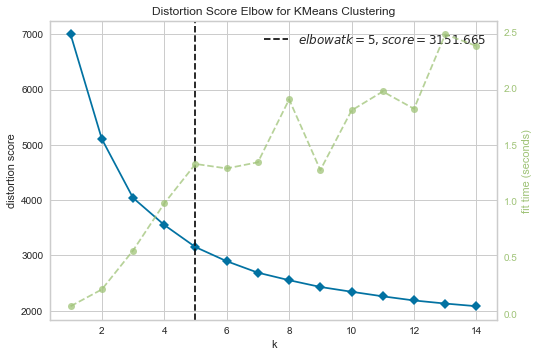

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c180a0cc0>,
         k=None, locate_elbow=True, metric='distortion', model=None,
         timings=True)

In [6]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

X = audio_features

kelbow_visualizer(KMeans(random_state=0), X, k=(1,15))

# source: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
# full reference in bibliography

The ideal k for my dataset is 5.

In [7]:
# convert dataframe columns to numpy array so that it works with my k-means algorithm

af_np = audio_features.to_numpy(copy=True)

In [8]:
# perform k-means on the audio features numpy array

centroids, labels = kmeans(af_np, 5, 1000)

In [9]:
# take a look at the clusters formed

audio_feat_list = audio_features.columns.tolist()
clusters = pd.DataFrame(centroids, columns=audio_feat_list)
clusters

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,0.503802,0.638107,0.588789,0.471782,0.172783,0.140833,0.468891,0.768757
1,0.916135,0.418326,0.198593,0.683303,0.188938,0.084621,0.406973,0.286399
2,0.048011,0.400478,0.725170,0.568776,0.189587,0.076959,0.521262,0.400765
3,0.249008,0.577735,0.599839,0.716268,0.188893,0.099696,0.429249,0.299736
4,0.847330,0.376222,0.710817,0.852952,0.206602,0.086137,0.508374,0.380838


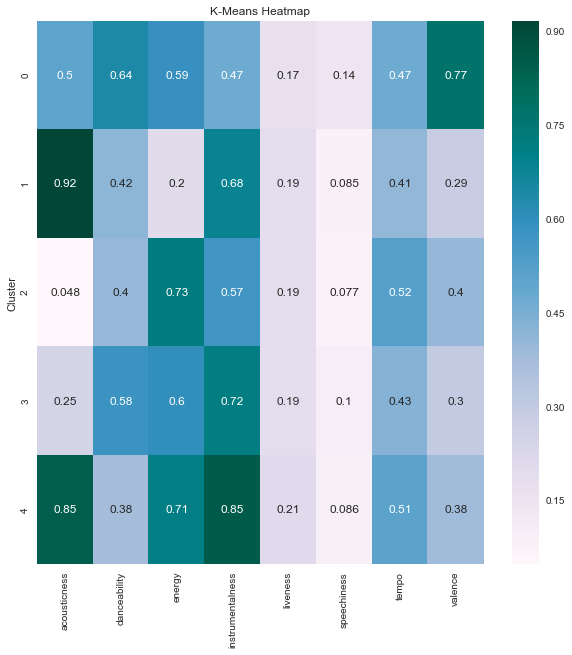

In [10]:
# visualize clusters in the form of a heatmap

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.heatmap(data=clusters,cmap='PuBuGn',annot=True)
plt.ylabel('Cluster')
plt.show()

Looks like the clusters formed are quite distinct from each other, which is good!

In [92]:
# add cluster labels to dataframe

tracks = audio_features.copy()
tracks['kmeans_label'] = labels
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,kmeans_label
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,0
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,3
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,0
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,0
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,0


In [93]:
# take a look at cluster sizes

tracks.groupby('kmeans_label').size()

kmeans_label
0    3119
1    3300
2    2612
3    2179
4    1919
dtype: int64

Now let's visualize the clusters formed! In order to plot high dimensional data on a 2D space, I will need to use a dimensionality reduction method. I decided to use PCA, as it is ideal for the size of this dataset.

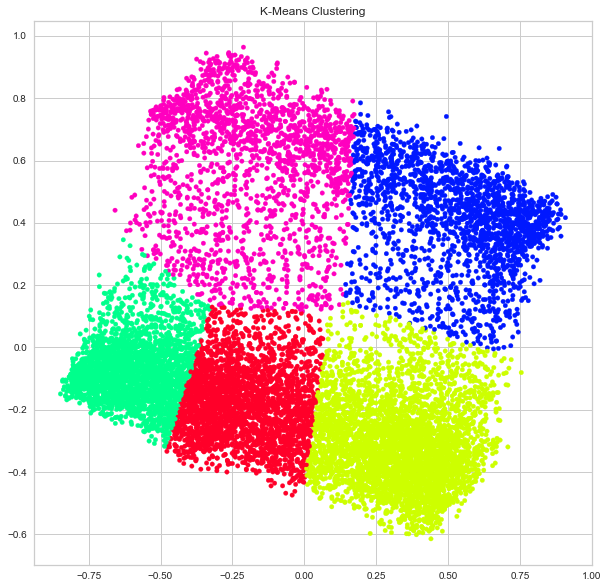

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(af_np)
pca_centroids, pca_labels = kmeans(X_pca, 5, 1000)
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, c=pca_labels, cmap='gist_rainbow')
plt.show()

The clusters formed are distinct and do not overlap, so I believe my algorithm has performed well. I decided to compare my visualization to that of the scikit-learn K-means algorithm to see if there's a significant difference.

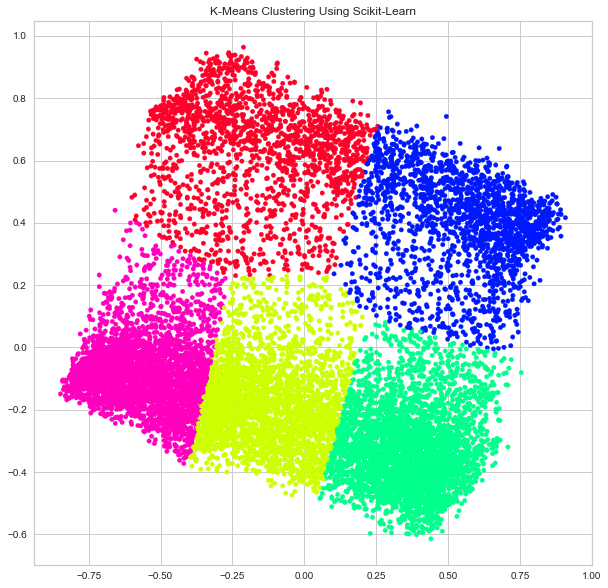

In [14]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_pca)
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, c=kmeans.labels_, cmap='gist_rainbow')
plt.show()

The clusters formed are very similar, showing that my algorithm has indeed performed well compared to the scikit-learn version.

Now let's try comparing my clusters with the true genre labels.

In [74]:
# read in the cleaned tracks with genres

track_genres = pd.read_csv('merged.csv', index_col='track_id')
track_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,genres,genres_all
track_id,,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop,[21],[21]
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop,[21],[21]
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop,[21],[21]
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop,[10],[10]
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop,[21],[21]


In [75]:
# take a look at the genres and their counts

track_genres.groupby('genre_top').size()

genre_top
Blues                   206
Classical               387
Electronic             3187
Experimental             17
Folk                   1100
Hip-Hop                 937
Indie-Rock               69
Instrumental             84
International           398
Jazz                    547
Metal                    12
Old-Time / Historic     412
Pop                    1399
Post-Rock                 9
Psych-Folk               88
Psych-Rock               37
Punk                     16
Rock                   4149
Soundtrack               51
Trip-Hop                 24
dtype: int64

I decided to merge several similar genres together in order to create 5 top genres to compare with my 5 clusters. I do this by comparing similarities between the mean audio features of each genre.

In [76]:
# find the mean audio features for each genre to merge similar ones

groups = track_genres.groupby('genre_top').agg('mean')
groups

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
genre_top,,,,,,,,
Blues,0.679041,0.498965,0.408592,0.467555,0.218809,0.077433,116.388539,0.485727
Classical,0.951297,0.346107,0.111337,0.755342,0.216919,0.075297,104.980889,0.251539
Electronic,0.339894,0.584479,0.609174,0.741754,0.174607,0.119443,124.659457,0.435730
Experimental,0.599967,0.573539,0.430228,0.506951,0.164140,0.091255,123.640412,0.617081
Folk,0.795626,0.436294,0.310816,0.615242,0.164357,0.063113,115.879338,0.357181
Hip-Hop,0.411054,0.623019,0.564882,0.358732,0.188644,0.251283,118.597536,0.590667
Indie-Rock,0.345674,0.545685,0.612887,0.658524,0.191736,0.073038,124.932435,0.405578
Instrumental,0.689762,0.504089,0.474841,0.656352,0.203607,0.097122,116.030714,0.365909
International,0.654534,0.536636,0.505165,0.561759,0.222302,0.114847,124.585905,0.575529


I merged rock/punk/metal into rock, although audio features could vary quite a bit due to the significant differences between hard and soft rock. Pop and Hip-Hop seem to have similar features, so those become one group. Blues and Folk are another core group, as is electronic and experimental. That leaves Classical, Instrumental, Jazz, and International, which have similar enough features to group together.

In [77]:
track_genres = track_genres.replace(['Indie-Rock', 'Metal', 'Post-Rock', 'Psych-Rock', 'Punk'], 'Rock')
track_genres = track_genres.replace(['Trip-Hop', 'Pop', 'Hip-Hop'], 'Pop/Hip-Hop')
track_genres = track_genres.replace(['Classical', 'Jazz', 'Old-Time / Historic', 'Instrumental', 'Soundtrack', 'International'], 'Classical/Jazz/International')
track_genres = track_genres.replace(['Electronic', 'Experimental'], 'Electronic/Experimental')
track_genres = track_genres.replace(['Blues', 'Folk', 'Psych-Folk'], 'Blues/Folk')
track_genres.groupby('genre_top').size()

genre_top
Blues/Folk                      1394
Classical/Jazz/International    1879
Electronic/Experimental         3204
Pop/Hip-Hop                     2360
Rock                            4292
dtype: int64

The distribution of these genres is quite different from my clusters - perhaps classical/jazz and soft rock could be more similar as a group, which would also even out the counts. However, I decided to continue to see how my clusters compare with these genres.

In [95]:
tracks['genre_top'] = track_genres['genre_top'].values
tracks.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,kmeans_label,genre_top
track_id,,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,0.642706,0.576661,0,Pop/Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,0.479206,0.269240,3,Pop/Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,0.367184,0.621661,0,Pop/Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,0.414608,0.963590,0,Pop/Hip-Hop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,0.426055,0.894072,0,Pop/Hip-Hop


In [79]:
# find the clusters that correspond to genres, according to genre counts

tracks[['genre_top', 'kmeans_label']].groupby('genre_top').agg(lambda x:x.value_counts().index[0])

# source: https://github.com/victoreram/Springboard-Data-Science/blob/master/GenreClustering/GenreClustering.ipynb
# full reference in bibliography

,kmeans_label
genre_top,
Blues/Folk,1
Classical/Jazz/International,1
Electronic/Experimental,3
Pop/Hip-Hop,0
Rock,2


In [80]:
# find the genres that correspond to clusters, according to cluster counts

tracks[['genre_top', 'kmeans_label']].groupby('kmeans_label').agg(lambda x:x.value_counts().index[0])

# source: https://github.com/victoreram/Springboard-Data-Science/blob/master/GenreClustering/GenreClustering.ipynb
# full reference in bibliography

,genre_top
kmeans_label,
0,Pop/Hip-Hop
1,Classical/Jazz/International
2,Rock
3,Electronic/Experimental
4,Rock


From these results, it is clear that some clusters have been identified accurately - Classical/Jazz/International, Electronic/Experimental, and Pop/Hip-Hop. Rock and Blues/Folk are the problem clusters, one of which I had hypothesized earlier. This is very likely due to the wide range of audio features in rock songs. It is a very diverse genre, so it would be difficult to classify accurately. It also would have been better to classify Classical/Instrumental as a separate group, although the number of tracks in this group would have been much lower compared to the rest.

Now let's use some clustering accuracy metrics to see how my algorithm has performed.

In [81]:
from sklearn import metrics

labels_true = tracks['genre_top']
labels_pred = tracks['kmeans_label']

# calculate the Adjusted Rand Score
metrics.adjusted_rand_score(labels_true, labels_pred)

0.06334589108094055

In [82]:
# calculate the Fowlkes Mallows score

metrics.fowlkes_mallows_score(labels_true, labels_pred)

0.268513023262701

In [83]:
# calculate the silhouette score

metrics.silhouette_score(audio_features, labels, metric='euclidean')

0.11213991048749244

From these measures, it seems like my algorithm has performed poorly. However, I believe music genre classification according to audio features is very subjective, due to the wide range of music and genres in existence. A better way to assess performance in this case would be through visualization of the clusters, which has been successful in identifying distinct groups of tracks based on their audio features.

I renamed my k-means clusters to a descriptive label based on their audio features and corresponding genre labels.

In [96]:
replace_labels = {
    0:'Pop/Hip-Hop',
    1:'Classical/Jazz/Blues/Folk',
    2:'Rock/Punk/Metal',
    3:'Electronic',
    4:'Acoustic/Instrumental Rock'
}

tracks = tracks.replace({'kmeans_label': replace_labels})

In [98]:
tracks.groupby('kmeans_label').size()

kmeans_label
Acoustic/Instrumental Rock    1919
Classical/Jazz/Blues/Folk     3300
Electronic                    2179
Pop/Hip-Hop                   3119
Rock/Punk/Metal               2612
dtype: int64

In [100]:
# save tracks with true and kmeans labels to a csv file

tracks.to_csv('tracks_kmeans.csv')